In [1]:
# Implements a buffer for faster readout
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
experiment_name = 'initial testing'
current_limit = 1.0e-6
voltage_limit = 3000
measurement_interval = 1.0e-4
operating_voltage = 10
measurement_count = 600
soak_time = 5

In [3]:
# Connect to keithley
rm = pyvisa.ResourceManager()
print(rm.list_resources())
keithley = rm.open_resource('GPIB1::11::INSTR')
print("Using " + keithley.query('*IDN?'))

('TCPIP0::18.25.28.214::inst0::INSTR', 'TCPIP0::18.62.7.104::inst0::INSTR', 'TCPIP0::18.25.28.21::inst0::INSTR', 'TCPIP0::18.25.25.62::inst0::INSTR', 'ASRL1::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8



In [4]:
keithley.write('smua.reset()')

14

In [12]:
# Configure as voltage source
keithley.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_FAST \n\
    smua.measure.interval = {m_int} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, m_int=measurement_interval))

446

In [13]:
keithley.write(' \
    smua.nvbuffer1.clear() \n\
	smua.nvbuffer1.collecttimestamps	= 1 \n\
	smua.nvbuffer1.collectsourcevalues	= 1 \n\
')

111

In [14]:
keithley.write('smua.source.levelv = %s'%operating_voltage)
keithley.write('smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

49

In [15]:
measurements = []
timestamps = []
counter = 1
for i in range(measurement_count):
    try:
        raw_measurement = keithley.query('print(smua.nvbuffer1[{iterate}])'.format(iterate=counter))
        raw_time = keithley.query('print(smua.nvbuffer1.timestamps[{iterate}])'.format(iterate=counter))
        measurements.append(float(raw_measurement[:-1]))
        timestamps.append(float(raw_time[:-1]))
        counter += 1
    except BaseException as e:
        break


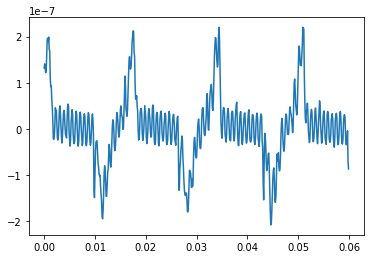

In [16]:
plt.plot(timestamps,measurements)
plt.show()

In [10]:
dts = []
for i in range(len(timestamps) - 1):
    dts.append(timestamps[i + 1] - timestamps[i])
print(np.average(dts))
print(1 / np.average(dts))

0.001
1000.0


In [17]:
aggregate_data = {'voltage':operating_voltage,'times':timestamps,'measured_currents':measurements}

filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//initial testing_ 2022_07_08-16_21_58.json'}


In [18]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
keithley.write("smua.source.levelv = 0")

print("Wait {}s until capacitors are fully discharged".format(soak_time))
time.sleep(soak_time)

print("Turning off output")
keithley.write("smua.source.output = 0")

print("Closing Keithley connection")
keithley.close()


Setting source voltage to 0 V
Wait 5s until capacitors are fully discharged
Turning off output
Closing Keithley connection
